# Discovering Binding Sites on a Viral Genome with SMEAGOL

This notebook demonstrates the functions for binding site discovery and enrichment. Here we use the genome of the SARS-CoV-2 coronavirus as an example.

## Import requirements

In [1]:
# General imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SMEAGOL imports
import smeagol.io, smeagol.models, smeagol.enrich, smeagol.visualize

In [2]:
pwms = pd.read_hdf('../VirusHostInteractionAtlas/DATA/PWMS/attract_rbpdb_filtered_human_pwms.h5', key='data')

## Load PWMs from RBPDB

We start this example by downloading a set of human PWMs and associated metadata from the RBPDB database.

In [3]:
!mkdir rbpdb
!wget http://rbpdb.ccbr.utoronto.ca/downloads/RBPDB_v1.3.1_human_2012-11-21_TDT.zip
!wget http://rbpdb.ccbr.utoronto.ca/downloads/matrices_human.zip
!unzip RBPDB_v1.3.1_human_2012-11-21_TDT -d rbpdb
!unzip matrices_human -d rbpdb
!rm RBPDB_v1.3.1_human_2012-11-21_TDT.zip
!rm matrices_human.zip

--2021-07-01 22:41:51--  http://rbpdb.ccbr.utoronto.ca/downloads/RBPDB_v1.3.1_human_2012-11-21_TDT.zip
Resolving rbpdb.ccbr.utoronto.ca (rbpdb.ccbr.utoronto.ca)... 142.150.52.218
Connecting to rbpdb.ccbr.utoronto.ca (rbpdb.ccbr.utoronto.ca)|142.150.52.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42726 (42K) [application/zip]
Saving to: ‘RBPDB_v1.3.1_human_2012-11-21_TDT.zip’

RBPDB_v1.3.1_human_ 100%[===================>]  41.72K   140KB/s    in 0.3s    

2021-07-01 22:41:52 (140 KB/s) - ‘RBPDB_v1.3.1_human_2012-11-21_TDT.zip’ saved [42726/42726]

--2021-07-01 22:41:52--  http://rbpdb.ccbr.utoronto.ca/downloads/matrices_human.zip
Resolving rbpdb.ccbr.utoronto.ca (rbpdb.ccbr.utoronto.ca)... 142.150.52.218
Connecting to rbpdb.ccbr.utoronto.ca (rbpdb.ccbr.utoronto.ca)|142.150.52.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22508 (22K) [application/zip]
Saving to: ‘matrices_human.zip’

matrices_human.zip  100%[================

PWMs are stored as individual files in the `PWMDir` directory. We can load these using the `read_pms_from_dir` function.

In [4]:
%time
pwms = smeagol.io.read_pms_from_dir('rbpdb/PWMDir', value_col='weight', transpose=True)
pwms.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


,Matrix_id,weight
0,953,"[[1.6425876, -1.7730861, -1.7730861, -1.773086..."
1,242,"[[0.98601563, -1.5303424, 0.2184107, -0.972431..."
2,969,"[[-2.8073549, -0.6918777, 0.81713594, 0.561878..."
3,149,"[[-1.4546965, -2.0535142, -1.032781, 1.5387887..."
4,24,"[[1.7435633, -2.2033739, -2.2033739, -2.203373..."


We can also read the metadata provided by RBPDB and add it to this Pandas dataframe.

In [5]:
%time
rbp = pd.read_csv("rbpdb/RBPDB_v1.3.1_proteins_human_2012-11-21.tdt", 
            header=None,  sep="\t", usecols=(0,4), names=('Prot_id', 'Gene_name'),
                 dtype='str')
rbp_pwm = pd.read_csv("rbpdb/RBPDB_v1.3.1_protExp_human_2012-11-21.tdt", 
            header=None,  sep="\t", usecols=(0,1), names=('Prot_id', 'Matrix_id'),
                 dtype='str')
rbp = rbp.merge(rbp_pwm, on='Prot_id')
pwms = pwms.merge(rbp.loc[:, ['Matrix_id', 'Gene_name']], on='Matrix_id')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [6]:
pwms.head()

,Matrix_id,weight,Gene_name
0,953,"[[1.6425876, -1.7730861, -1.7730861, -1.773086...",SFRS2
1,242,"[[0.98601563, -1.5303424, 0.2184107, -0.972431...",SFRS1
2,969,"[[-2.8073549, -0.6918777, 0.81713594, 0.561878...",YTHDC1
3,149,"[[-1.4546965, -2.0535142, -1.032781, 1.5387887...",QKI
4,24,"[[1.7435633, -2.2033739, -2.2033739, -2.203373...",PABPC1


In [7]:
len(pwms)

56

## Analyze position matrices

We have multiple matrices for some RBPs. To see how many distinct RBPs are in the list:

In [8]:
len(pd.unique(pwms.Gene_name))

30

We can select a particular PWM using its `Matrix_id`:

In [9]:
pwms[pwms.Matrix_id=='242']

,Matrix_id,weight,Gene_name
1,242,"[[0.98601563, -1.5303424, 0.2184107, -0.972431...",SFRS1


We can also select all PWMs for an RBP:

In [10]:
pwms[pwms.Gene_name=='SFRS1']

,Matrix_id,weight,Gene_name
1,242,"[[0.98601563, -1.5303424, 0.2184107, -0.972431...",SFRS1
13,1173,"[[0.65450337, -1.0, -0.39733409, 0.2223916], [...",SFRS1
43,952,"[[1.0339473, -0.9328858, -0.9328858, -0.144389...",SFRS1
44,243,"[[1.5090976, -1.3787187, -1.3787187, -1.378718...",SFRS1


We can plot any PWM in `pwms` as follows:

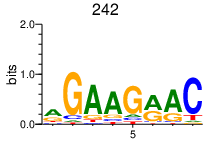

In [11]:
smeagol.visualize.plot_pwm(pwms, Matrix_id='242')

Finally, we encode all these PWMs as a convolutional model. This will allow us to scan genome sequence(s).

In [12]:
model = smeagol.models.PWMModel(pwms)

2021-07-01 22:41:54.127178: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the genome

We will download the FASTA file containing the viral genome to analyze.

In [13]:
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/009/858/895/GCA_009858895.3_ASM985889v3/GCA_009858895.3_ASM985889v3_genomic.fna.gz

--2021-07-01 22:41:54--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/009/858/895/GCA_009858895.3_ASM985889v3/GCA_009858895.3_ASM985889v3_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 165.112.9.228
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9592 (9.4K) [application/x-gzip]
Saving to: ‘GCA_009858895.3_ASM985889v3_genomic.fna.gz’

GCA_009858895.3_ASM 100%[===================>]   9.37K  --.-KB/s    in 0.004s  

2021-07-01 22:41:54 (2.28 MB/s) - ‘GCA_009858895.3_ASM985889v3_genomic.fna.gz’ saved [9592/9592]



We need to specify whether this is a `+` or `-` sense viral genome.

In [14]:
genome_sense = '+'

We now read the genome sequence, and store it an object called `genome`:

In [15]:
%%time
genome = smeagol.io.read_fasta('GCA_009858895.3_ASM985889v3_genomic.fna.gz')

Read 1 records from GCA_009858895.3_ASM985889v3_genomic.fna.gz
CPU times: user 15.4 ms, sys: 7.94 ms, total: 23.3 ms
Wall time: 29.1 ms


In [16]:
genome

[SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='MN908947.3', name='MN908947.3', description='MN908947.3 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome', dbxrefs=[])]

In this case, the viral genome has a single segment. However, we can analyze multi-segment genomes in exactly the same way - simply include the sequences of all the segments in the same FASTA file.

In [17]:
genome_len = sum([len(x) for x in genome])
genome_len

29903

In [18]:
encoded = smeagol.encode.MultiSeqEncoding(genome, rcomp=True, sense='+')

In [19]:
model = smeagol.models.PWMModel(pwms)

## Number of binding sites found at various thresholds

We generate a background distribution by shuffling the genome sequence multiple times. We need to specify two parameters:

In [20]:
simN=100 # Number of times to shuffle
simK=2 # k-mer length to keep fixed

We begin by demonstrating how to get the distribution of number of binding sites by score. We begin by selecting a preliminary, low threshold of 0.5. 
In the process, we can also choose whether to encode and scan the reverse complement sequence. To encode and scan the reverse complement sequence as well as the given sequence, we would specify `rcomp=True`. To scan only the given sequence, use `rcomp=False`.

In [21]:
rcomp=False

We will now scan the real genome and the shuffled genome sequences for binding sites, and count the number of sites based on their score. This can take a long time!

In [22]:
%time
threshold_binned_results = smeagol.enrich.examine_thresholds(genome, model, simN, simK, rcomp, sense=genome_sense, 
                                              min_threshold=0.5, verbose=True, combine_seqs=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Shuffled 1 input sequence(s) 100 times while conserving k-mer frequency for k = 2


2021-07-01 22:41:56.857450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


We can view the first few shuffled sequences:

In [23]:
threshold_binned_results['shuf_seqs'][:3]

[SeqRecord(seq=Seq('ATATAAATTAGACAGTTACATGCCAAGTATTGCTACGATGAGAGTACTACACCA...TCA'), id='background_seq_1', name='MN908947.3', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('ATCTCTGCATGACTAAAATGCACTGATTATACAAATAACACAATTGTGTACAAA...TCA'), id='background_seq_2', name='MN908947.3', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('ATATCGAAGTAGACTCAAAAAAGAAGATGACGTTATACAACTTTTACTCTCCTG...TTA'), id='background_seq_3', name='MN908947.3', description='<unknown description>', dbxrefs=[])]

`real_binned` now contains the number of binding sites found for each PWM, binned by score. We can view the first few entries:

In [24]:
threshold_binned_results['real_binned'].head()

,Matrix_id,sense,bin,num
0,1052,+,"(0.5, 0.6]",15
1,1052,+,"(0.6, 0.7]",16
2,1052,+,"(0.7, 0.8]",0
3,1052,+,"(0.8, 0.9]",50
4,1052,+,"(0.9, 1.0]",0


The `num` column records the number of binding sites per PWM, per bin.

We plot the distribution of binding sites on the real genome for a given PWM. Here, we are plotting the distribution of binding sites only on the `+` sense sequence.

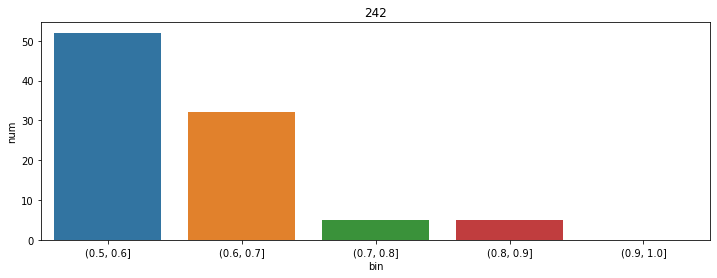

In [25]:
smeagol.visualize.plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='242', sense ='+')

`shuf_binned` contains the number of binding sites per bin, in the shuffled genomes.

In [26]:
threshold_binned_results['shuf_binned'].head()

,Matrix_id,sense,bin,id,num
0,1004,+,"(0.5, 0.6]",background_seq_1,0
1,1004,+,"(0.5, 0.6]",background_seq_10,0
2,1004,+,"(0.5, 0.6]",background_seq_100,0
3,1004,+,"(0.5, 0.6]",background_seq_11,0
4,1004,+,"(0.5, 0.6]",background_seq_12,0


We can now plot the distribution of binding sites per bin for the real and shuffled genome sequences, for any given PWM.

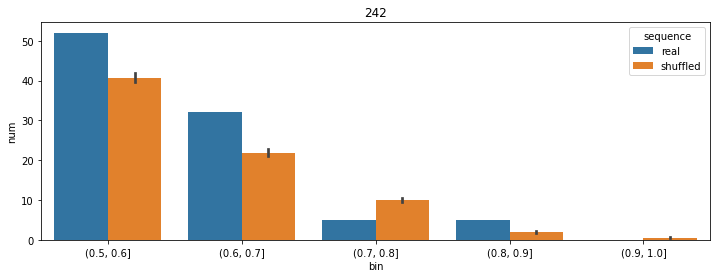

In [27]:
smeagol.visualize.plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='242', 
                                         sense ='+', shuf_preds=threshold_binned_results['shuf_binned'])

### Binding site discovery and enrichment for a specified threshold

Based on this exploration, we can select a higher threshold to identify binding sites, and test for enrichment of PWM matching sites in the genome using a simple function.

In [28]:
simN=300
simK=2
rcomp=True
threshold=0.8

In [29]:
%%time
enrichment_result = smeagol.enrich.enrich_in_genome(genome, model, simN=simN, simK=simK, rcomp=rcomp, 
                                     sense=genome_sense, threshold=threshold, verbose=True, 
                                     combine_seqs=True, background='binomial')

Shuffled 1 input sequence(s) 300 times while conserving k-mer frequency for k = 2


/Users/avantika/Desktop/viruslandscape/vir2/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


CPU times: user 53.8 s, sys: 43.7 s, total: 1min 37s
Wall time: 1min 54s


In [30]:
enrichment_result.keys()

dict_keys(['enrichment', 'real_sites', 'real_counts', 'shuf_stats', 'shuf_counts', 'shuf_seqs'])

We can view the locations of the binding sites:

In [31]:
real_sites = enrichment_result['real_sites']
real_sites.head()

,id,name,sense,start,Matrix_id,width,end,score,max_score,frac_score
0,MN908947.3,MN908947.3,+,0,1174,6,6,4.092388,4.652089,0.879688
1,MN908947.3,MN908947.3,+,3,1169,7,10,4.293839,5.110522,0.840196
2,MN908947.3,MN908947.3,+,7,1170,4,11,4.403590,4.403591,1.000000
3,MN908947.3,MN908947.3,+,17,1217,5,22,23.000000,25.000000,0.920000
4,MN908947.3,MN908947.3,+,19,922,4,23,5.268256,5.268255,1.000000


And the number of binding sites per PWM in the real genome:

In [32]:
real_counts = enrichment_result['real_counts']
real_counts.head()

,Matrix_id,sense,num
0,1052,+,107
1,1052,-,89
2,1053,+,57
3,1053,-,20
4,1169,+,151


We can plot the distribution of number of binding sites per PWM, per strand:

<AxesSubplot:xlabel='num', ylabel='Count'>

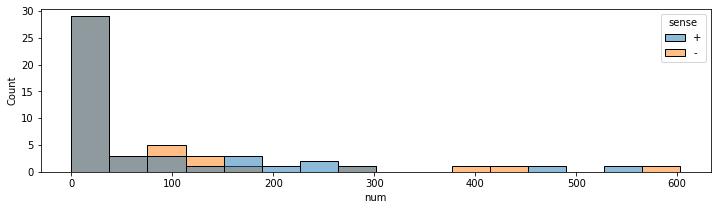

In [33]:
plt.figure(figsize=(12, 3))
sns.histplot(data=real_counts, x='num', hue='sense', bins='auto')

We can see the number of binding sites found on the shuffled genomes:

In [34]:
shuf_counts = enrichment_result['shuf_counts']
shuf_counts.head()

,Matrix_id,sense,id,num
0,1052,+,background_seq_1,97
1,1052,+,background_seq_10,98
2,1052,+,background_seq_100,106
3,1052,+,background_seq_101,99
4,1052,+,background_seq_102,94


In [35]:
shuf_stats = enrichment_result['shuf_stats']
shuf_stats.head()

,Matrix_id,sense,len,avg,sd
0,1052,+,300,95.283333,9.669612
1,1052,-,300,126.686667,10.295394
2,1053,+,300,38.006667,5.942305
3,1053,-,300,46.486667,6.472723
4,1169,+,300,109.386667,9.738237


We can examine the enrichment for each PWM.

In [36]:
enr = enrichment_result['enrichment']
enr.head()

,Matrix_id,sense,num,len,avg,sd,p,fdr
0,637,+,157.0,300,100.363333,9.429087,1.377994e-07,0.000008
1,1169,+,151.0,300,109.386667,9.738237,1.492690e-04,0.004105
2,669,+,283.0,300,228.330000,13.250901,4.253819e-04,0.005849
3,947,+,5.0,300,0.573333,0.739218,3.211501e-04,0.005849
4,1053,+,57.0,300,38.006667,5.942305,3.391700e-03,0.035516


We can separate out the PWMs that are enriched / depleted on each strand:

In [37]:
enr_pos = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='+')].reset_index(drop=True) # enriched on + strand
enr_neg = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='-')].reset_index(drop=True) # enriched on - strand
dep_pos = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='+')].reset_index(drop=True) # depleted on + strand
dep_neg = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='-')].reset_index(drop=True) # depleted on - strand

print(len(enr_pos))
print(len(enr_neg))
print(len(dep_pos))
print(len(dep_neg))

5
3
1
5


We can view the PWMs enriched on the `+` strand:

In [38]:
enr_pos

,Matrix_id,sense,num,len,avg,sd,p,fdr
0,637,+,157.0,300,100.363333,9.429087,1.377994e-07,0.000008
1,1169,+,151.0,300,109.386667,9.738237,1.492690e-04,0.004105
2,669,+,283.0,300,228.330000,13.250901,4.253819e-04,0.005849
3,947,+,5.0,300,0.573333,0.739218,3.211501e-04,0.005849
4,1053,+,57.0,300,38.006667,5.942305,3.391700e-03,0.035516


And match these to RBPs:

In [39]:
enr_pos = enr_pos.merge(pwms.loc[:,['Matrix_id', 'Gene_name']])
enr_pos.head()

,Matrix_id,sense,num,len,avg,sd,p,fdr,Gene_name
0,637,+,157.0,300,100.363333,9.429087,1.377994e-07,0.000008,FUS
1,1169,+,151.0,300,109.386667,9.738237,1.492690e-04,0.004105,SFRS13A
2,669,+,283.0,300,228.330000,13.250901,4.253819e-04,0.005849,MBNL1
3,947,+,5.0,300,0.573333,0.739218,3.211501e-04,0.005849,SNRPA
4,1053,+,57.0,300,38.006667,5.942305,3.391700e-03,0.035516,RBMY1A1


We can plot the number of binding sites for any PWM in windows across the genome:

In [40]:
r = smeagol.enrich.count_in_sliding_windows(real_sites[real_sites.sense=='+'], genome, '637', 1000)
r.head()

,id,start,end,count
0,MN908947.3,0,1000,6
1,MN908947.3,1000,2000,7
2,MN908947.3,2000,3000,10
3,MN908947.3,3000,4000,6
4,MN908947.3,4000,5000,8


We can visualize the counts across the genome using the `sliding_window_count_plot`. Note that if the viral genome had multiple segments, this function would create a separate plot for each segment.

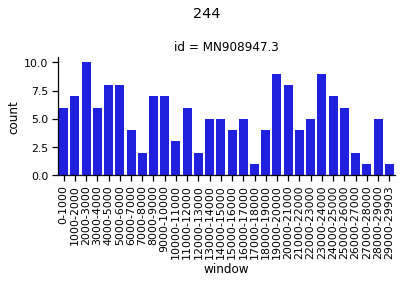

In [41]:
smeagol.visualize.sliding_window_count_plot(r, cols=1, title='244')

## Enrichment plot

We can plot the distribution of binding sites for any set of PWMs. Here we plot the distributions for the enriched PWMs on the `+` sense genome.

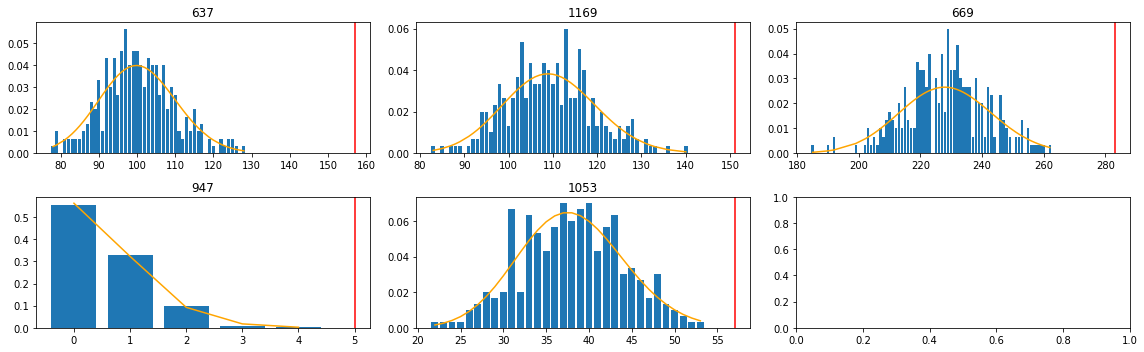

In [42]:
smeagol.visualize.plot_background(shuf_counts[shuf_counts.sense=="+"], 
                                  real_counts[real_counts.sense=="+"], 
                enr_pos.Matrix_id, genome_len, background='binomial', 
                figsize=(16,5), ncols=3)

## Enrichment in sliding windows

For any given PWM, we can test for enrichment of its binding sites in sliding windows across the genome using Fisher's exact test. Here we test for enrichment of a specific PWM in the positive ('+') sense genome.

In [43]:
r = smeagol.enrich.enrich_in_sliding_windows(real_sites[real_sites.sense=="+"], genome, '24', 500)
r.head()

,id,start,end,len,count,tot_count,expected,odds,p,padj
0,MN908947.3,0,500,500,1,85,1.421262,0.703006,1.000000,1.000000
1,MN908947.3,500,1000,500,0,85,1.421262,0.000000,0.408347,0.765651
2,MN908947.3,1000,1500,500,1,85,1.421262,0.703006,1.000000,1.000000
3,MN908947.3,1500,2000,500,3,85,1.421262,2.117505,0.176682,0.765651
4,MN908947.3,2000,2500,500,1,85,1.421262,0.703006,1.000000,1.000000


We select significantly enriched bins:

In [44]:
r[(r.padj<0.05) & (r.odds > 1)]

,id,start,end,len,count,tot_count,expected,odds,p,padj
59,MN908947.3,29500,29903,403,29,85,1.145537,27.20107,5.157308e-29,3.094385e-27


and significantly depleted bins:

In [45]:
r[(r.padj<0.05) & (r.odds < 1)]

,id,start,end,len,count,tot_count,expected,odds,p,padj


## Plot enrichment/depletion  in sliding windows

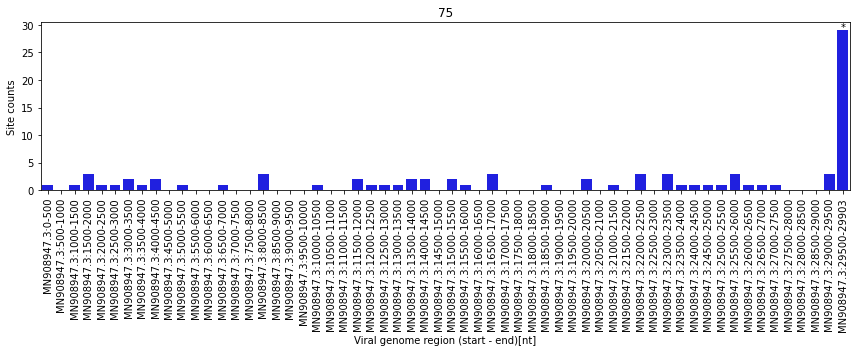

In [46]:
r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start)+'-'+str(row.end), axis=1)
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, 
                            x_var='window', 
                            y_var='count', 
                            xticklabels='window_name', title='75')